In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sn
# import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.layers import RandomFlip, RandomTranslation
import glob, random
from PIL import Image
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

2.10.1


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# Specify the path to the FER 2013 dataset directory and the output directories
fer2013_directory = "train/"  # Replace with your actual dataset path
output_directory = "stratify"  # Where you want to save the split data

# List of class labels in FER 2013
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Create output directories for training and validation data
train_directory = os.path.join(output_directory, "train")
val_directory = os.path.join(output_directory, "val")
os.makedirs(train_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)

# Initialize dictionaries to store image file paths for each class
class_images = {label: [] for label in class_labels}

# Collect image file paths for each class
for label in class_labels:
    class_directory = os.path.join(fer2013_directory, label)
    class_images[label] = [os.path.join(class_directory, image_name) for image_name in os.listdir(class_directory)]

# Initialize dictionaries to store the split image file paths
train_images = {label: [] for label in class_labels}
val_images = {label: [] for label in class_labels}

# Perform the stratified split into training and validation sets
for label in class_labels:
    images = class_images[label]
    train_class_images, val_class_images = train_test_split(images, test_size=0.25, random_state=42, stratify=[label] * len(images))
    train_images[label] = train_class_images
    val_images[label] = val_class_images

# Move images to the corresponding directories for the split
for label in class_labels:
    for image_path in train_images[label]:
        output_directory = os.path.join(train_directory, label)
        os.makedirs(output_directory, exist_ok=True)
        shutil.copy(image_path, output_directory)

    for image_path in val_images[label]:
        output_directory = os.path.join(val_directory, label)
        os.makedirs(output_directory, exist_ok=True)
        shutil.copy(image_path, output_directory)

KeyboardInterrupt: 

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255
                                  )

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = 'stratify/train/',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                #    subset = 'training',
                                                   batch_size = 64)

Found 21529 images belonging to 7 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'stratify/val/',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                #   subset = 'validation',
                                                  batch_size = 64)

Found 7180 images belonging to 7 classes.


In [9]:
test_dataset = test_datagen.flow_from_directory(directory = 'test/',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [10]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [11]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [12]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [14]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


In [16]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
from PIL import Image
import scipy as sp
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/100
337/337 [==============================] - 164s 442ms/step - loss: 1.9247 - accuracy: 0.8552 - precision: 0.2012 - recall: 0.0046 - auc: 0.6005 - f1_score: 0.0088 - val_loss: 1.8174 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6457 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
337/337 [==============================] - 31s 91ms/step - loss: 1.8336 - accuracy: 0.8570 - precision: 0.2742 - recall: 7.8963e-04 - auc: 0.6382 - f1_score: 0.0015 - val_loss: 1.7770 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6732 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/100
337/337 [==============================] - 30s 88ms/step - loss: 1.7850 - accuracy: 0.8571 - precision: 0.4868 - recall: 0.0068 - auc: 0.6704 - f1_score: 0.0133 - val_loss: 1.7534 - val_accuracy: 0.8572 - val_precision: 0.5455 - val_recall: 8.3565e-04 - val_auc: 0.6894 - val_f1_score: 0.0016 - lr: 0.0010
Epoch 4/100
337/337 [===

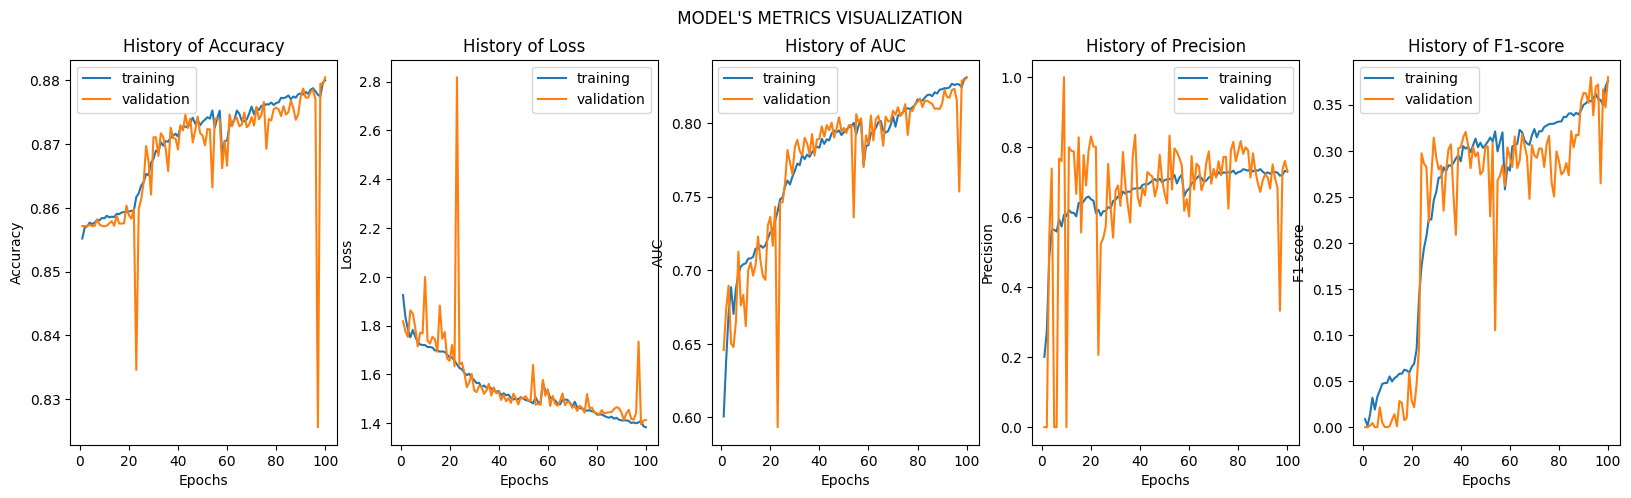

In [20]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )